In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import numpy as np
from scipy.stats import norm
np.random.seed(0)

X = np.linspace(-5,5,num=20)
X0 = X*np.random.rand(len(X))+10 # Create data cluster 1
X1 = X*np.random.rand(len(X))-10 # Create data cluster 2
X2 = X*np.random.rand(len(X)) # Create data cluster 3
X_tot = np.stack((X0,X1,X2)).flatten() # Combine the clusters to get the random datapoints from above



"""Create the array r with dimensionality nxK"""
r = np.zeros((len(X_tot),3))  
print('Dimensionality','=',np.shape(r))

"""Instantiate the random gaussians"""

gauss_1 = norm(loc=-5,scale=5) 
gauss_2 = norm(loc=8,scale=3)
gauss_3 = norm(loc=1.5,scale=1)

"""Instantiate the random pi_c"""
pi = np.array([1/3,1/3,1/3]) # We expect to have three clusters 


"""
Probability for each datapoint x_i to belong to gaussian g 
"""
for c,g,p in zip(range(3),[gauss_1,gauss_2,gauss_3],pi):
    r[:,c] = p*g.pdf(X_tot) # Write the probability that x belongs to gaussian c in column c. 
                          # Therewith we get a 60x3 array filled with the probability that each x_i belongs to one of the gaussians
"""
Normalize the probabilities such that each row of r sums to 1 and weight it by pi_c == the fraction of points belonging to 
cluster c
"""
for i in range(len(r)):
    r[i] = r[i]/(np.sum(pi)*np.sum(r,axis=1)[i])

"""In the last calculation we normalized the probabilites r_ic. So each row i in r gives us the probability for x_i 
to belong to one gaussian (one column per gaussian). Since we want to know the probability that x_i belongs 
to gaussian g, we have to do smth. like a simple calculation of percentage where we want to know how likely it is in % that
x_i belongs to gaussian g. To realize this we must dive the probability of each r_ic by the total probability r_i (this is done by 
summing up each row in r and divide each value r_ic by sum(np.sum(r,axis=1)[r_i] )). To get this,
look at the above plot and pick an arbitrary datapoint. Pick one gaussian and imagine the probability that this datapoint
belongs to this gaussian. This value will normally be small since the point is relatively far away right? So what is
the percentage that this point belongs to the chosen gaussian? --> Correct, the probability that this datapoint belongs to this 
gaussian divided by the sum of the probabilites for this datapoint and all three gaussians. Since we don't know how many
point belong to each cluster c and threwith to each gaussian c, we have to make assumptions and in this case simply said that we 
assume that the points are equally distributed over the three clusters."""
    
print(r)
print(np.sum(r,axis=1)) # As we can see, as result each row sums up to one, just as we want it.

Dimensionality = (60, 3)
[[2.97644006e-02 9.70235407e-01 1.91912550e-07]
 [3.85713024e-02 9.61426220e-01 2.47747304e-06]
 [2.44002651e-02 9.75599713e-01 2.16252823e-08]
 [1.86909096e-02 9.81309090e-01 8.07574590e-10]
 [1.37640773e-02 9.86235923e-01 9.93606589e-12]
 [1.58674083e-02 9.84132592e-01 8.42447356e-11]
 [1.14191259e-02 9.88580874e-01 4.48947365e-13]
 [1.34349421e-02 9.86565058e-01 6.78305927e-12]
 [1.11995848e-02 9.88800415e-01 3.18533028e-13]
 [8.57645259e-03 9.91423547e-01 1.74498648e-15]
 [7.64696969e-03 9.92353030e-01 1.33051021e-16]
 [7.10275112e-03 9.92897249e-01 2.22285146e-17]
 [6.36154765e-03 9.93638452e-01 1.22221112e-18]
 [4.82376290e-03 9.95176237e-01 1.55549544e-22]
 [7.75866904e-03 9.92241331e-01 1.86665135e-16]
 [7.52759691e-03 9.92472403e-01 9.17205413e-17]
 [8.04550643e-03 9.91954494e-01 4.28205323e-16]
 [3.51864573e-03 9.96481354e-01 9.60903037e-30]
 [3.42631418e-03 9.96573686e-01 1.06921949e-30]
 [3.14390460e-03 9.96856095e-01 3.91217273e-35]
 [1.00000000e+0

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

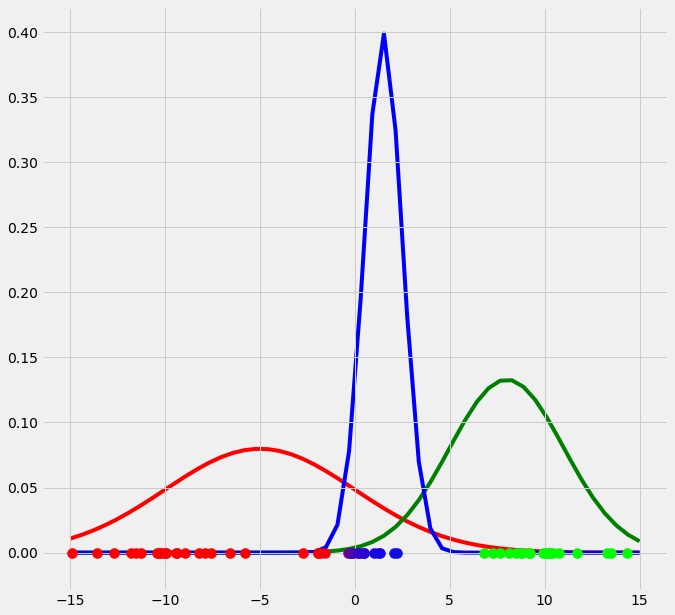

In [2]:
"""Plot the data"""
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)

for i in range(len(r)):
    ax0.scatter(X_tot[i],0,c=np.array([r[i][0],r[i][1],r[i][2]]),s=100) # We have defined the first column as red, the second as
                                                                        # green and the third as blue

for g,c in zip([gauss_1.pdf(np.linspace(-15,15)),gauss_2.pdf(np.linspace(-15,15)),gauss_3.pdf(np.linspace(-15,15))],['r','g','b']):
    ax0.plot(np.linspace(-15,15),g,c=c,zorder=0)
       
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

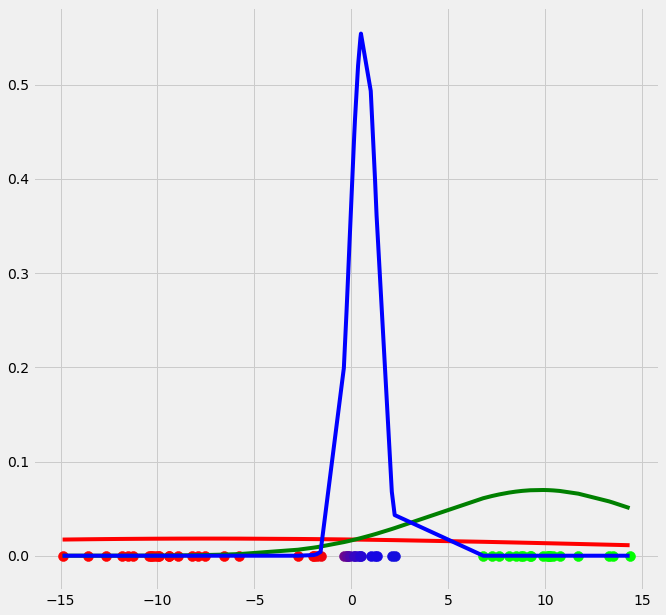

In [3]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import numpy as np
from scipy.stats import norm
np.random.seed(0)

X = np.linspace(-5,5,num=20)
X0 = X*np.random.rand(len(X))+10 # Create data cluster 1
X1 = X*np.random.rand(len(X))-10 # Create data cluster 2
X2 = X*np.random.rand(len(X)) # Create data cluster 3
X_tot = np.stack((X0,X1,X2)).flatten() # Combine the clusters to get the random datapoints from above

"""
E-Step
"""

"""Create the array r with dimensionality nxK"""
r = np.zeros((len(X_tot),3))  

"""Instantiate the random gaussians"""

gauss_1 = norm(loc=-5,scale=5) 
gauss_2 = norm(loc=8,scale=3)
gauss_3 = norm(loc=1.5,scale=1)

"""Instantiate the random mu_c"""
m = np.array([1/3,1/3,1/3]) # We expect to have three clusters 

pi = m/np.sum(m)


"""
Probability for each datapoint x_i to belong to gaussian g 
"""
for c,g,p in zip(range(3),[gauss_1,gauss_2,gauss_3],pi):
    r[:,c] = p*g.pdf(X_tot) # Write the probability that x belongs to gaussian c in column c. 
                          # Therewith we get a 60x3 array filled with the probability that each x_i belongs to one of the gaussians
"""
Normalize the probabilities such that each row of r sums to 1 and weight it by mu_c == the fraction of points belonging to 
cluster c
"""
for i in range(len(r)):
    r[i] = r[i]/(np.sum(pi)*np.sum(r,axis=1)[i])


"""M-Step"""


"""calculate m_c"""
m_c = []
for c in range(len(r[0])):
    m = np.sum(r[:,c])
    m_c.append(m) # For each cluster c, calculate the m_c and add it to the list m_c
    
"""calculate pi_c"""
pi_c = []
for m in m_c:
    pi_c.append(m/np.sum(m_c)) # For each cluster c, calculate the fraction of points pi_c which belongs to cluster c

"""calculate mu_c"""
mu_c = np.sum(X_tot.reshape(len(X_tot),1)*r,axis=0)/m_c


"""calculate var_c"""
var_c = []

for c in range(len(r[0])):
    var_c.append((1/m_c[c])*np.dot(((np.array(r[:,c]).reshape(60,1))*(X_tot.reshape(len(X_tot),1)-mu_c[c])).T,(X_tot.reshape(len(X_tot),1)-mu_c[c])))
      
    
"""Update the gaussians"""
gauss_1 = norm(loc=mu_c[0],scale=var_c[0]) 
gauss_2 = norm(loc=mu_c[1],scale=var_c[1])
gauss_3 = norm(loc=mu_c[2],scale=var_c[2])



"""Plot the data"""
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
for i in range(len(r)):
    ax0.scatter(X_tot[i],0,c=np.array([r[i][0],r[i][1],r[i][2]]),s=100) 


"""Plot the gaussians"""
for g,c in zip([gauss_1.pdf(np.sort(X_tot).reshape(60,1)),gauss_2.pdf(np.sort(X_tot).reshape(60,1)),gauss_3.pdf(np.sort(X_tot).reshape(60,1))],['r','g','b']):
    ax0.plot(np.sort(X_tot),g,c=c)
    
plt.show()

In [0]:

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import numpy as np
from scipy.stats import norm
np.random.seed(0)

X = np.linspace(-5,5,num=20)
X0 = X*np.random.rand(len(X))+15 # Create data cluster 1
X1 = X*np.random.rand(len(X))-15 # Create data cluster 2
X2 = X*np.random.rand(len(X)) # Create data cluster 3
X_tot = np.stack((X0,X1,X2)).flatten() # Combine the clusters to get the random datapoints from above

class GM1D:

    def __init__(self,X,iterations):
        self.iterations = iterations
        self.X = X
        self.mu = None
        self.pi = None
        self.var = None
  

    def run(self):
        

        """
        Instantiate the random mu, pi and var
        """
        self.mu = [-8,8,5]
        self.pi = [1/3,1/3,1/3]
        self.var = [5,3,1]
        
        
        
        """
        E-Step
        """
        
        for iter in range(self.iterations):

            """Create the array r with dimensionality nxK"""
            r = np.zeros((len(X_tot),3))  

  
            """
            Probability for each datapoint x_i to belong to gaussian g 
            """
            for c,g,p in zip(range(3),[norm(loc=self.mu[0],scale=self.var[0]),
                                       norm(loc=self.mu[1],scale=self.var[1]),
                                       norm(loc=self.mu[2],scale=self.var[2])],self.pi):
                r[:,c] = p*g.pdf(X_tot) # Write the probability that x belongs to gaussian c in column c. 
                                      # Therewith we get a 60x3 array filled with the probability that each x_i belongs to one of the gaussians
            """
            Normalize the probabilities such that each row of r sums to 1 and weight it by mu_c == the fraction of points belonging to 
            cluster c
            """
            for i in range(len(r)):
                r[i] = r[i]/(np.sum(pi)*np.sum(r,axis=1)[i])


            """Plot the data"""

            fig = plt.figure(figsize=(10,10))
            ax0 = fig.add_subplot(111)


            for i in range(len(r)):
                ax0.scatter(self.X[i],0,c=np.array([r[i][0],r[i][1],r[i][2]]),s=100) 


            """Plot the gaussians"""


            for g,c in zip([norm(loc=self.mu[0],scale=self.var[0]).pdf(np.linspace(-20,20,num=60)),
                            norm(loc=self.mu[1],scale=self.var[1]).pdf(np.linspace(-20,20,num=60)),
                            norm(loc=self.mu[2],scale=self.var[2]).pdf(np.linspace(-20,20,num=60))],['r','g','b']):
                ax0.plot(np.linspace(-20,20,num=60),g,c=c)
            
            
            
            """M-Step"""
    

            """calculate m_c"""
            m_c = []
            for c in range(len(r[0])):
                m = np.sum(r[:,c])
                m_c.append(m) # For each cluster c, calculate the m_c and add it to the list m_c

            """calculate pi_c"""
            for k in range(len(m_c)):
                self.pi[k] = (m_c[k]/np.sum(m_c)) # For each cluster c, calculate the fraction of points pi_c which belongs to cluster c

            """calculate mu_c"""
            self.mu = np.sum(self.X.reshape(len(self.X),1)*r,axis=0)/m_c


            """calculate var_c"""
            var_c = []

            for c in range(len(r[0])):
                var_c.append((1/m_c[c])*np.dot(((np.array(r[:,c]).reshape(60,1))*(self.X.reshape(len(self.X),1)-self.mu[c])).T,(self.X.reshape(len(self.X),1)-self.mu[c])))



            plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

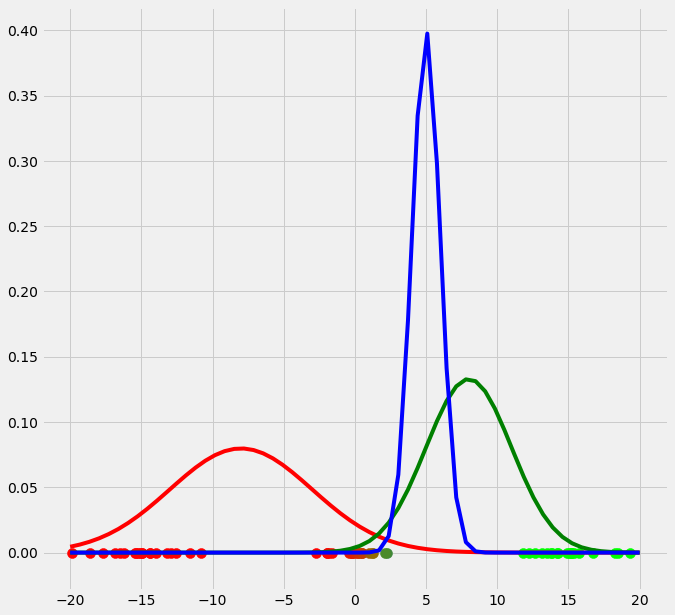

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

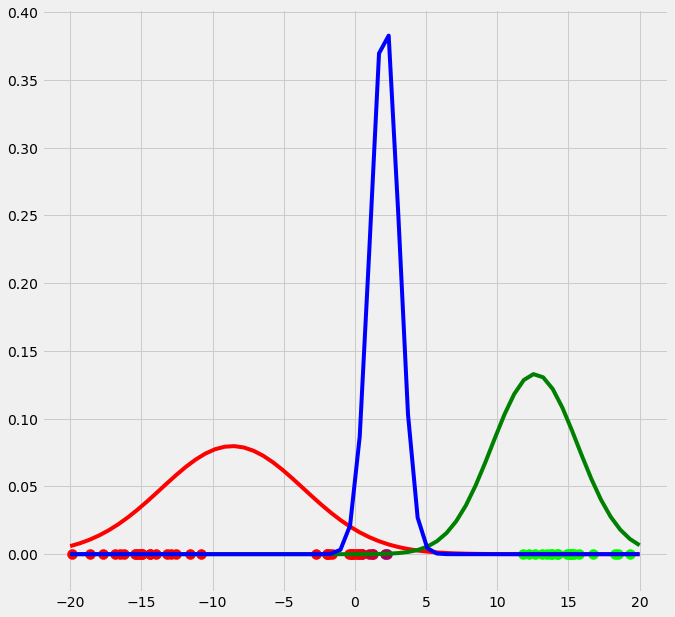

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

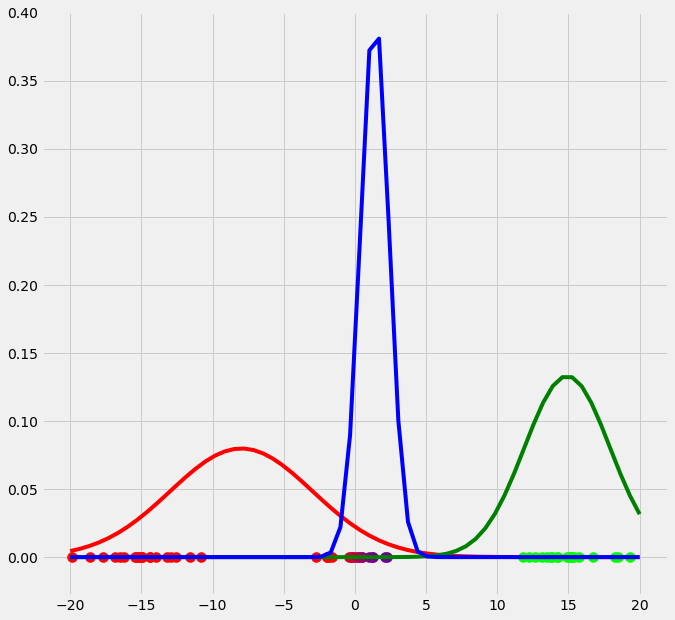

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

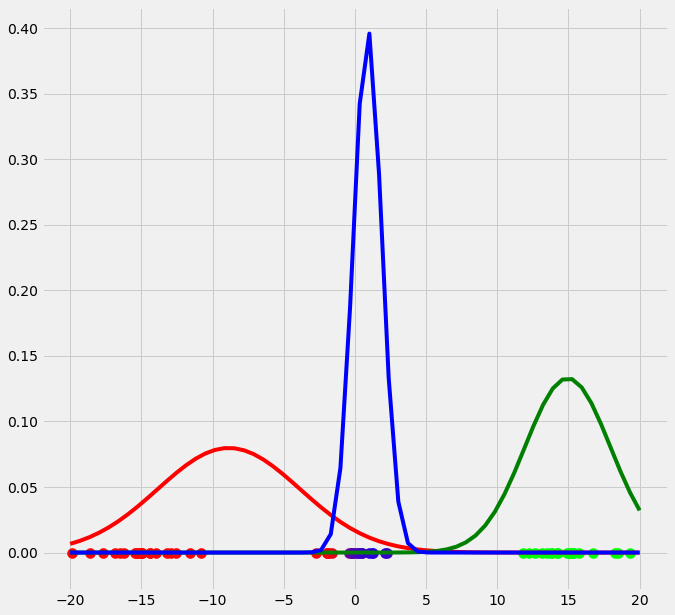

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

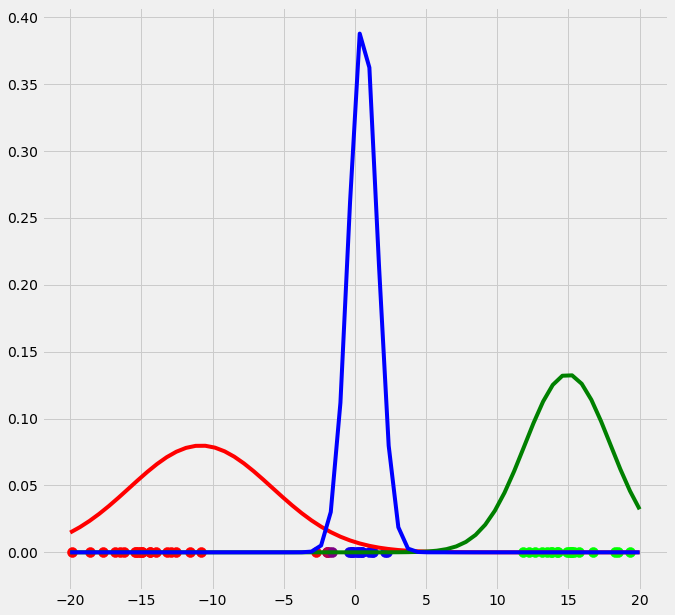

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

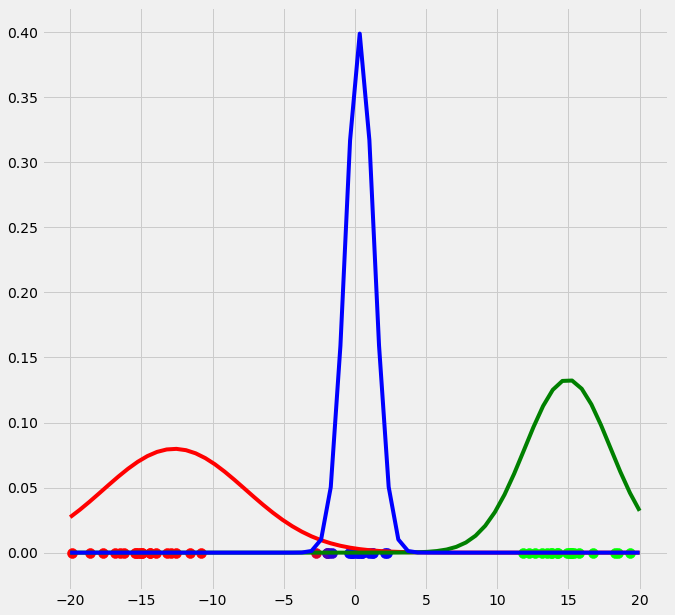

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

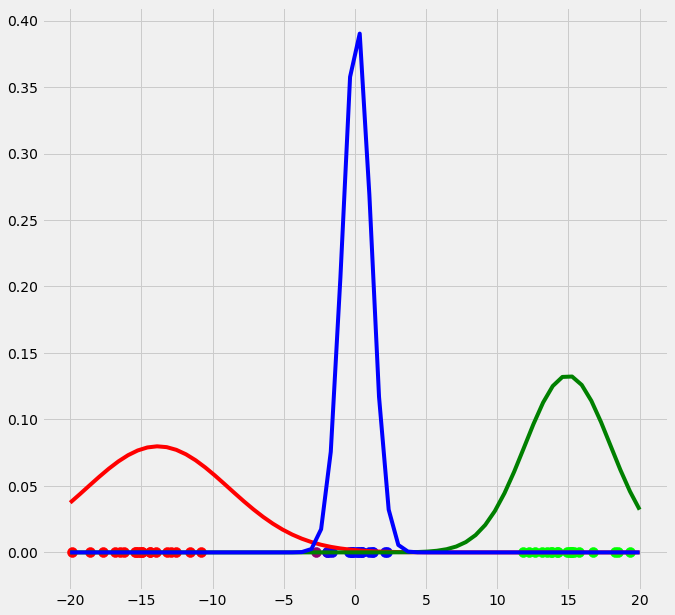

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

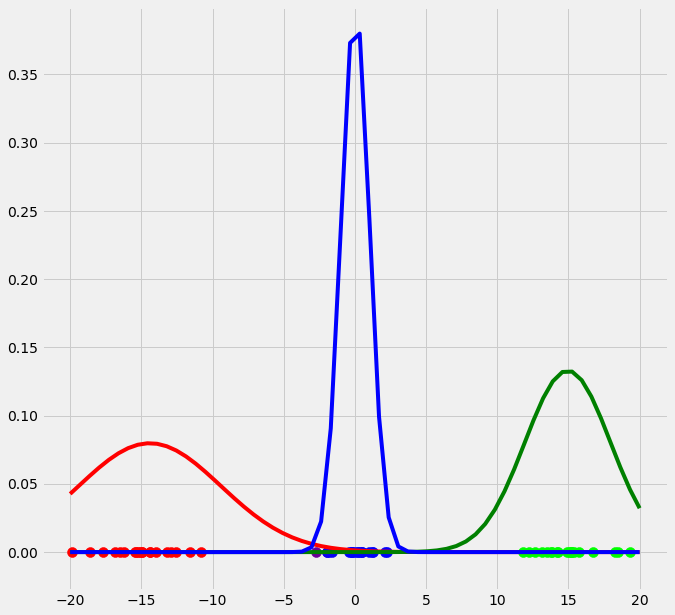

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

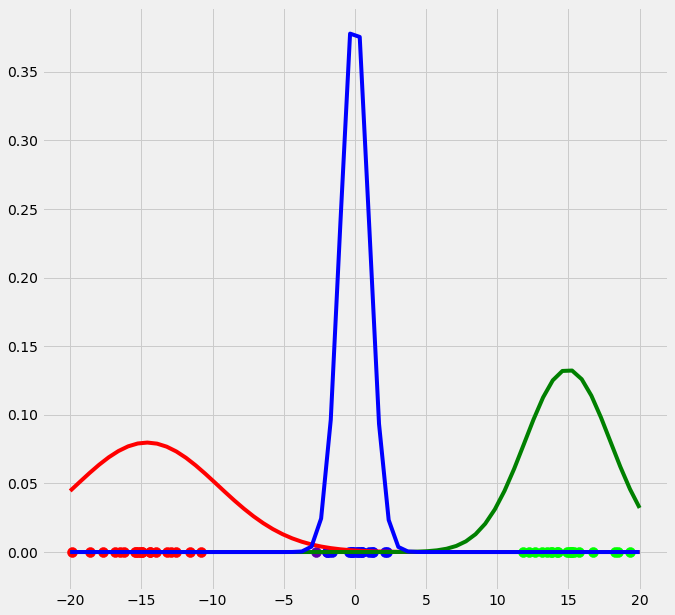

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

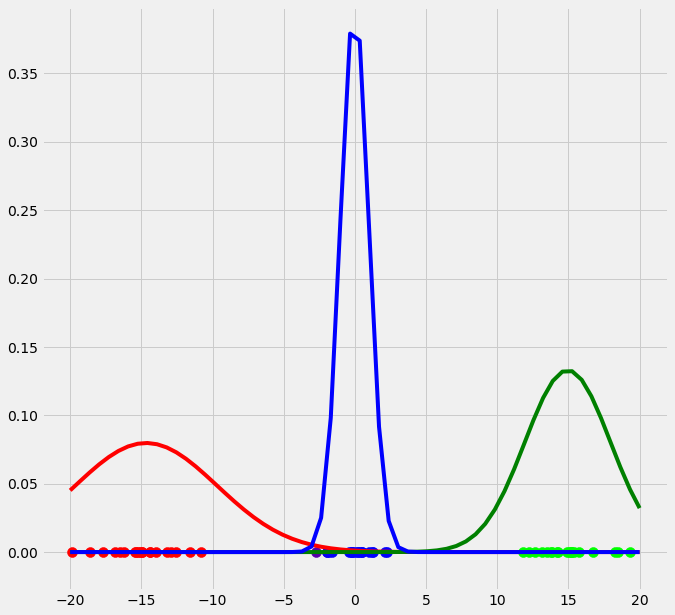

In [5]:
GM1D = GM1D(X_tot,10)
GM1D.run()

In [0]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
from scipy.stats import multivariate_normal


# 0. Create dataset
X,Y = make_blobs(cluster_std=1.5,random_state=20,n_samples=500,centers=3)

# Stratch dataset to get ellipsoid data
X = np.dot(X,np.random.RandomState(0).randn(2,2))


class GMM:

    def __init__(self,X,number_of_sources,iterations):
        self.iterations = iterations
        self.number_of_sources = number_of_sources
        self.X = X
        self.mu = None
        self.pi = None
        self.cov = None
        self.XY = None
        
    

    """Define a function which runs for iterations, iterations"""
    def run(self):
        self.reg_cov = 1e-6*np.identity(len(self.X[0]))
        x,y = np.meshgrid(np.sort(self.X[:,0]),np.sort(self.X[:,1]))
        self.XY = np.array([x.flatten(),y.flatten()]).T
           
                    
        """ 1. Set the initial mu, covariance and pi values"""
        self.mu = np.random.randint(min(self.X[:,0]),max(self.X[:,0]),size=(self.number_of_sources,len(self.X[0]))) # This is a nxm matrix since we assume n sources (n Gaussians) where each has m dimensions
        self.cov = np.zeros((self.number_of_sources,len(X[0]),len(X[0]))) # We need a nxmxm covariance matrix for each source since we have m features --> We create symmetric covariance matrices with ones on the digonal
        for dim in range(len(self.cov)):
            np.fill_diagonal(self.cov[dim],5)


        self.pi = np.ones(self.number_of_sources)/self.number_of_sources # Are "Fractions"
        log_likelihoods = [] # In this list we store the log likehoods per iteration and plot them in the end to check if
                             # if we have converged
            
        """Plot the initial state"""    
        fig = plt.figure(figsize=(10,10))
        ax0 = fig.add_subplot(111)
        ax0.scatter(self.X[:,0],self.X[:,1])
        ax0.set_title('Initial state')
        for m,c in zip(self.mu,self.cov):
            c += self.reg_cov
            multi_normal = multivariate_normal(mean=m,cov=c)
            ax0.contour(np.sort(self.X[:,0]),np.sort(self.X[:,1]),multi_normal.pdf(self.XY).reshape(len(self.X),len(self.X)),colors='black',alpha=0.3)
            ax0.scatter(m[0],m[1],c='grey',zorder=10,s=100)
        
        for i in range(self.iterations):               

            """E Step"""
            r_ic = np.zeros((len(self.X),len(self.cov)))

            for m,co,p,r in zip(self.mu,self.cov,self.pi,range(len(r_ic[0]))):
                co+=self.reg_cov
                mn = multivariate_normal(mean=m,cov=co)
                r_ic[:,r] = p*mn.pdf(self.X)/np.sum([pi_c*multivariate_normal(mean=mu_c,cov=cov_c).pdf(X) for pi_c,mu_c,cov_c in zip(self.pi,self.mu,self.cov+self.reg_cov)],axis=0)

            """
            The above calculation of r_ic is not that obvious why I want to quickly derive what we have done above.
            First of all the nominator:
            We calculate for each source c which is defined by m,co and p for every instance x_i, the multivariate_normal.pdf() value.
            For each loop this gives us a 100x1 matrix (This value divided by the denominator is then assigned to r_ic[:,r] which is in 
            the end a 100x3 matrix).
            Second the denominator:
            What we do here is, we calculate the multivariate_normal.pdf() for every instance x_i for every source c which is defined by
            pi_c, mu_c, and cov_c and write this into a list. This gives us a 3x100 matrix where we have 100 entrances per source c.
            Now the formula wants us to add up the pdf() values given by the 3 sources for each x_i. Hence we sum up this list over axis=0.
            This gives us then a list with 100 entries.
            What we have now is FOR EACH LOOP a list with 100 entries in the nominator and a list with 100 entries in the denominator
            where each element is the pdf per class c for each instance x_i (nominator) respectively the summed pdf's of classes c for each 
            instance x_i. Consequently we can now divide the nominator by the denominator and have as result a list with 100 elements which we
            can then assign to r_ic[:,r] --> One row r per source c. In the end after we have done this for all three sources (three loops)
            and run from r==0 to r==2 we get a matrix with dimensionallity 100x3 which is exactly what we want.
            If we check the entries of r_ic we see that there mostly one element which is much larger than the other two. This is because
            every instance x_i is much closer to one of the three gaussians (that is, much more likely to come from this gaussian) than
            it is to the other two. That is practically speaing, r_ic gives us the fraction of the probability that x_i belongs to class
            c over the probability that x_i belonges to any of the classes c (Probability that x_i occurs given the 3 Gaussians).
            """

            """M Step"""

            # Calculate the new mean vector and new covariance matrices, based on the probable membership of the single x_i to classes c --> r_ic
            self.mu = []
            self.cov = []
            self.pi = []
            log_likelihood = []

            for c in range(len(r_ic[0])):
                m_c = np.sum(r_ic[:,c],axis=0)
                mu_c = (1/m_c)*np.sum(self.X*r_ic[:,c].reshape(len(self.X),1),axis=0)
                self.mu.append(mu_c)

                # Calculate the covariance matrix per source based on the new mean
                self.cov.append(((1/m_c)*np.dot((np.array(r_ic[:,c]).reshape(len(self.X),1)*(self.X-mu_c)).T,(self.X-mu_c)))+self.reg_cov)
                # Calculate pi_new which is the "fraction of points" respectively the fraction of the probability assigned to each source 
                self.pi.append(m_c/np.sum(r_ic)) # Here np.sum(r_ic) gives as result the number of instances. This is logical since we know 
                                                # that the columns of each row of r_ic adds up to 1. Since we add up all elements, we sum up all
                                                # columns per row which gives 1 and then all rows which gives then the number of instances (rows) 
                                                # in X --> Since pi_new contains the fractions of datapoints, assigned to the sources c,
                                                # The elements in pi_new must add up to 1

            
            
            """Log likelihood"""
            log_likelihoods.append(np.log(np.sum([k*multivariate_normal(self.mu[i],self.cov[j]).pdf(X) for k,i,j in zip(self.pi,range(len(self.mu)),range(len(self.cov)))])))

            

            """
            This process of E step followed by a M step is now iterated a number of n times. In the second step for instance,
            we use the calculated pi_new, mu_new and cov_new to calculate the new r_ic which are then used in the second M step
            to calculat the mu_new2 and cov_new2 and so on....
            """

        fig2 = plt.figure(figsize=(10,10))
        ax1 = fig2.add_subplot(111) 
        ax1.set_title('Log-Likelihood')
        ax1.plot(range(0,self.iterations,1),log_likelihoods)
        #plt.show()
    
    """Predict the membership of an unseen, new datapoint"""
    def predict(self,Y):
        # PLot the point onto the fittet gaussians
        fig3 = plt.figure(figsize=(10,10))
        ax2 = fig3.add_subplot(111)
        ax2.scatter(self.X[:,0],self.X[:,1])
        for m,c in zip(self.mu,self.cov):
            multi_normal = multivariate_normal(mean=m,cov=c)
            ax2.contour(np.sort(self.X[:,0]),np.sort(self.X[:,1]),multi_normal.pdf(self.XY).reshape(len(self.X),len(self.X)),colors='black',alpha=0.3)
            ax2.scatter(m[0],m[1],c='grey',zorder=10,s=100)
            ax2.set_title('Final state')
            for y in Y:
                ax2.scatter(y[0],y[1],c='orange',zorder=10,s=100)
        prediction = []        
        for m,c in zip(self.mu,self.cov):  
            #print(c)
            prediction.append(multivariate_normal(mean=m,cov=c).pdf(Y)/np.sum([multivariate_normal(mean=mean,cov=cov).pdf(Y) for mean,cov in zip(self.mu,self.cov)]))
        #plt.show()
        return prediction

[3.579907995583901e-06, 0.00013180910068621356, 0.9998646109913182]

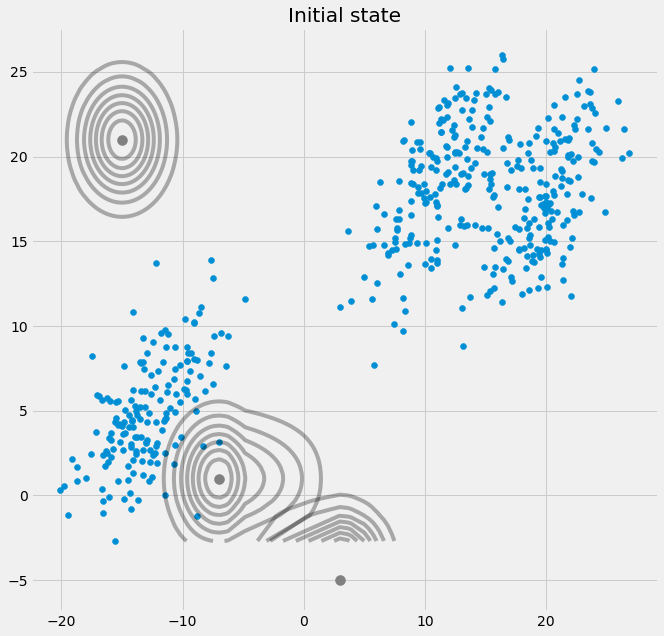

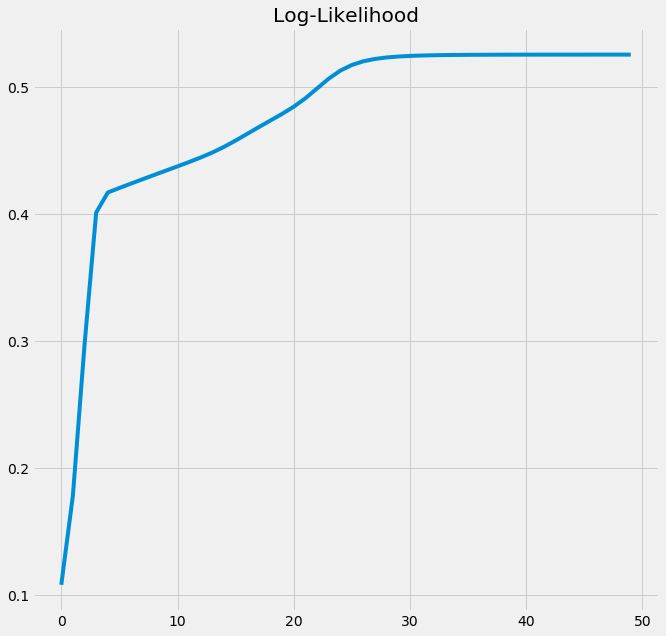

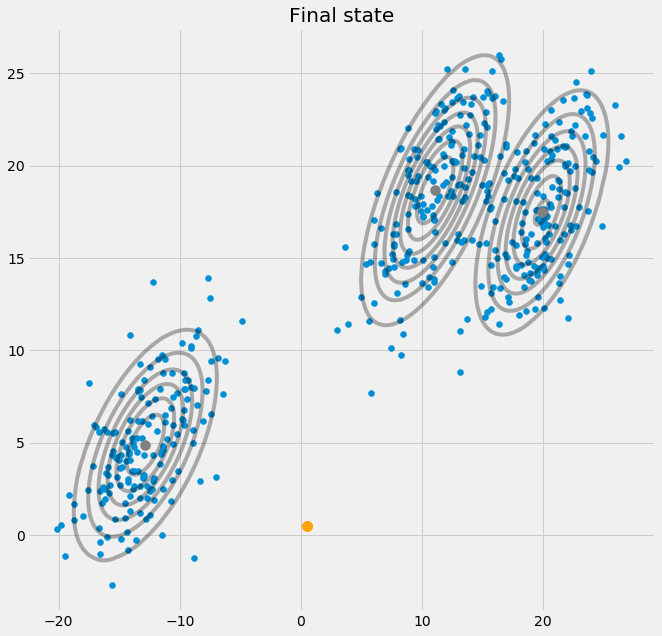

In [7]:
GMM = GMM(X,3,50)     
GMM.run()
GMM.predict([[0.5,0.5]])

Converged: True
[[1.94756664e-93 1.00000000e+00 4.00098007e-33 9.36305075e-82
  5.02664415e-44]]


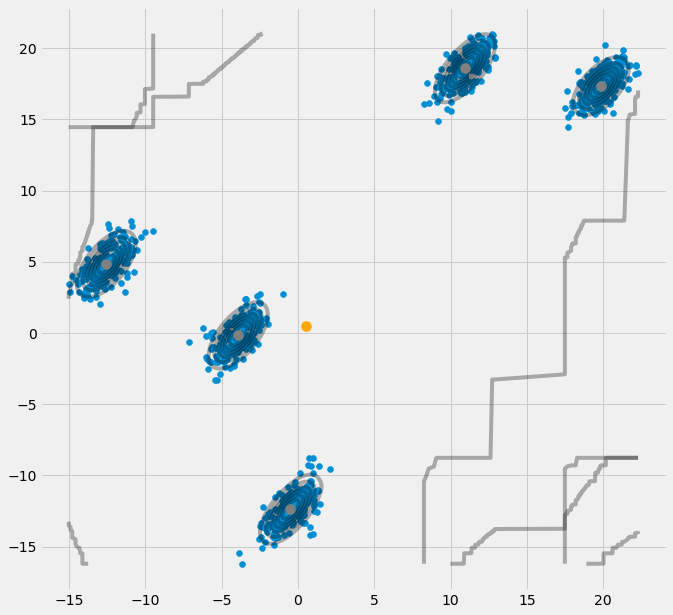

In [8]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

# 0. Create dataset
X,Y = make_blobs(cluster_std=0.5,random_state=20,n_samples=1000,centers=5)

# Stratch dataset to get ellipsoid data
X = np.dot(X,np.random.RandomState(0).randn(2,2))

x,y = np.meshgrid(np.sort(X[:,0]),np.sort(X[:,1]))
XY = np.array([x.flatten(),y.flatten()]).T

GMM = GaussianMixture(n_components=5).fit(X) # Instantiate and fit the model
print('Converged:',GMM.converged_) # Check if the model has converged
means = GMM.means_ 
covariances = GMM.covariances_


# Predict
Y = np.array([[0.5],[0.5]])
prediction = GMM.predict_proba(Y.T)
print(prediction)

# Plot   
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
ax0.scatter(X[:,0],X[:,1])
ax0.scatter(Y[0,:],Y[1,:],c='orange',zorder=10,s=100)
for m,c in zip(means,covariances):
    multi_normal = multivariate_normal(mean=m,cov=c)
    ax0.contour(np.sort(X[:,0]),np.sort(X[:,1]),multi_normal.pdf(XY).reshape(len(X),len(X)),colors='black',alpha=0.3)
    ax0.scatter(m[0],m[1],c='grey',zorder=10,s=100)
    
plt.show()